In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
rc('figure', facecolor='w')
from astropy.io import fits, ascii
from astropy.table import Table
from collections import OrderedDict
import os
import math

import TheCannon
from TheCannon import apogee, dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

line_list = ap.lines
line_names = line_list.keys()

/home/jess/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [168]:
dfile = AP_PATH + '/training_sets/mann_bonus/'
rfile = 'train_ref/bonus_ref_labels.csv'  

ids, wl, tr_flux, tr_ivar = apogee.load_spectra(dfile)
tr_ID = np.array([x.split('2-')[1].split('.fits')[0] for x in ids])
tr_label = ap.loadLabels(rfile, lbl_names=['TEFF', 'FEH'])
# tr_label = ap.scaleLabels(ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H']))

wave = ap.rvShift(wl, rv=-80)
ds = dataset.Dataset(wave, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar)
ds.set_label_names(['T_{eff}', '[Fe/H]'])
ds.tr_label.shape, ds.tr_ID.shape, ds.tr_flux.shape, ds.tr_ivar.shape

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/apogee_data/training_sets/mann_bonus/
Spectra loaded


((76, 2), (76,), (76, 8575), (76, 8575))

In [169]:
md, ds, synth = ap.fitCannonModel(ds)
np.save('bonus_cross_validation_run2/model_coeff_fullset', md.coeffs)

Done training model. 
Inferring Labels


In [53]:
ds.diagnostics_1to1()

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png


In [48]:
# trn_labels, tst_labels, crv_labels = ap.crossValidate(ds, save_dir='bonus_cross_validation_run2/')

In [170]:
# np.save('bonus_cross_validation_run2/trn_labels', trn_labels)
# np.save('bonus_cross_validation_run2/tst_labels', tst_labels)
# np.save('bonus_cross_validation_run2/crv_labels', crv_labels)

trn_labels = np.load('bonus_cross_validation_run2/trn_labels.npy')
tst_labels = np.load('bonus_cross_validation_run2/tst_labels.npy')
crv_labels = np.load('bonus_cross_validation_run2/crv_labels.npy')

In [171]:
trn_teff = np.array(trn_labels).T[0]
trn_fe_h = np.array(trn_labels).T[1]
tst_teff = np.array(tst_labels).T[0]
tst_fe_h = np.array(tst_labels).T[1]
crv_teff = np.array(crv_labels).T[0]
crv_fe_h = np.array(crv_labels).T[1]

tst_teff_err = trn_teff - tst_teff 
crv_teff_err = trn_teff - crv_teff 
tst_fe_h_err = trn_fe_h - tst_fe_h
crv_fe_h_err = trn_fe_h - crv_fe_h 
teff_tst_crv_diff = tst_teff - crv_teff
fe_h_tst_crv_diff = tst_fe_h - crv_fe_h

In [99]:
d = {'ID':tr_ID, 'SAMPLE':pd.read_csv(rfile)['SAMPLE'], 'TRAIN_TEFF':trn_teff, 'TEST_TEFF':tst_teff, 'CROSS_TEFF':crv_teff, \
     'TEST_TEFF_ERR':tst_teff_err, 'CROSS_TEFF_ERR':crv_teff_err, \
     'TEST_CROSS_DIFF_TEFF':teff_tst_crv_diff, \
     'TRAIN_FEH':trn_fe_h, 'TEST_FEH':tst_fe_h, 'CROSS_FEH':crv_fe_h, \
     'TEST_FEH_ERR':tst_teff_err, 'CROSS_FEH_ERR':crv_teff_err, \
     'TEST_CROSS_DIFF_FEH':fe_h_tst_crv_diff}

df = pd.DataFrame(data=OrderedDict(d))
df.to_csv('bonus_sample_results.csv')

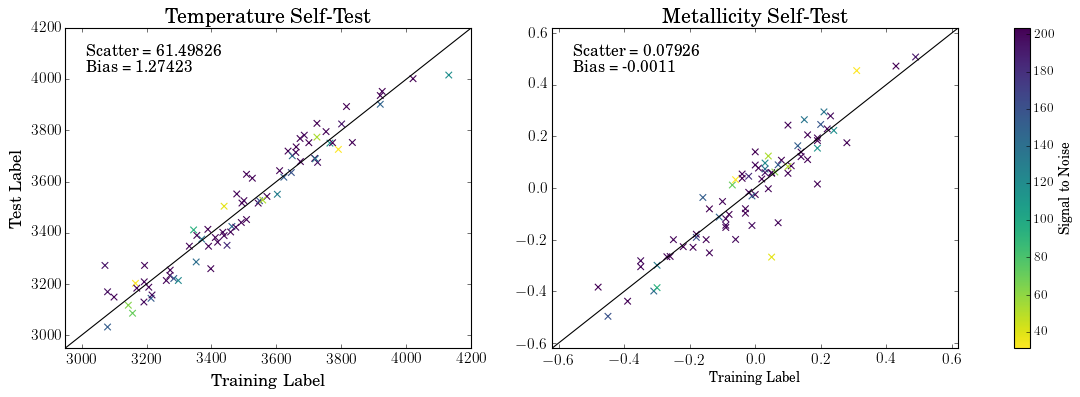

In [172]:
x = np.arange(-1,4300)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])

scat1, bias1 = np.round(np.std(tst_teff_err),5), np.round(np.mean(tst_teff_err),5)
scat2, bias2 = np.round(np.std(tst_fe_h_err),5), np.round(np.mean(tst_fe_h_err),5)
text1 = 'Scatter = %s \n Bias = %s'%(scat1, bias1)
text2 = 'Scatter = %s \n Bias = %s'%(scat2, bias2)

pl = ax1.scatter(trn_teff, tst_teff, marker='x', c=ds.test_SNR, s=35, cmap='viridis_r')
ax1.plot(x,x, color='k')
ax1.text(0.05, 0.95, text1, fontsize=14, transform=ax1.transAxes, verticalalignment='top')
ax1.set_xlim(2950,4200)
ax1.set_ylim(2950,4200)
ax1.set_xlabel('Training Label', fontsize=15)
ax1.set_ylabel('Test Label', fontsize=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Temperature Self-Test', fontsize=18)

ax2.scatter(trn_fe_h, tst_fe_h, marker='x', c=ds.test_SNR, s=35, cmap='viridis_r')
ax2.plot(x,x, color='k')
ax2.text(0.05, 0.95, text2, fontsize=14, transform=ax2.transAxes, verticalalignment='top')
ax2.set_xlim(-.62,.62)
ax2.set_ylim(-.62,.62)
ax2.set_xlabel('Training Label')
ax2.set_title('Metallicity Self-Test', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
cb.set_label('Signal to Noise', fontsize=12)
plt.show()

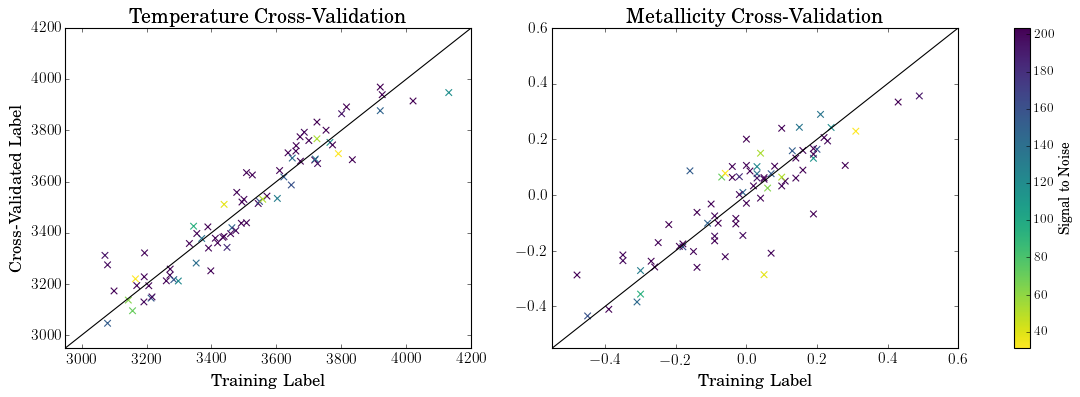

In [89]:
x = np.arange(-1,4300)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,5])
ax1.scatter(trn_teff, crv_teff, c=ds.test_SNR, marker='x', s=35, cmap='viridis_r')
ax1.plot(x,x, color='k')
ax1.set_xlim(2950,4200)
ax1.set_ylim(2950,4200)
ax1.set_xlabel('Training Label', fontsize=15)
ax1.set_ylabel('Cross-Validated Label', fontsize=15)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_title('Temperature Cross-Validation', fontsize=18)

ax2.scatter(trn_fe_h, crv_fe_h, c=ds.test_SNR, marker='x', s=35, cmap='viridis_r')
ax2.plot(x,x, color='k')
ax2.set_xlim(-.55,.6)
ax2.set_ylim(-.55,.6)
ax2.set_xlabel('Training Label', fontsize=15)
ax2.set_title('Metallicity Cross-Validation', fontsize=18)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
cb = plt.colorbar(pl, ax=(ax1,ax2), orientation='vertical')
cb.set_label('Signal to Noise', fontsize=12)
plt.show()

In [101]:
N = tr_label.shape[0]
coeff_n = np.array([np.load('bonus_cross_validation_run2/model_coeff_'+str(i)+'.npy') for i in range(N)])
coeff_full = np.load('bonus_cross_validation_run2/model_coeff_fullset.npy')

def jackknife(l,m):
    
    diff_sq = 0
    for n in range(N): #star
        diff_sq += (coeff_n[n][m][l] - coeff_full[m][l])**2
    
    s = (N-1)/N * diff_sq 
    
    return math.sqrt(s)

npix = len(ds.wl)
jack_err_teff = np.array([jackknife(3,m) for m in range(npix)])
jack_err_fe_h = np.array([jackknife(4,m) for m in range(npix)])

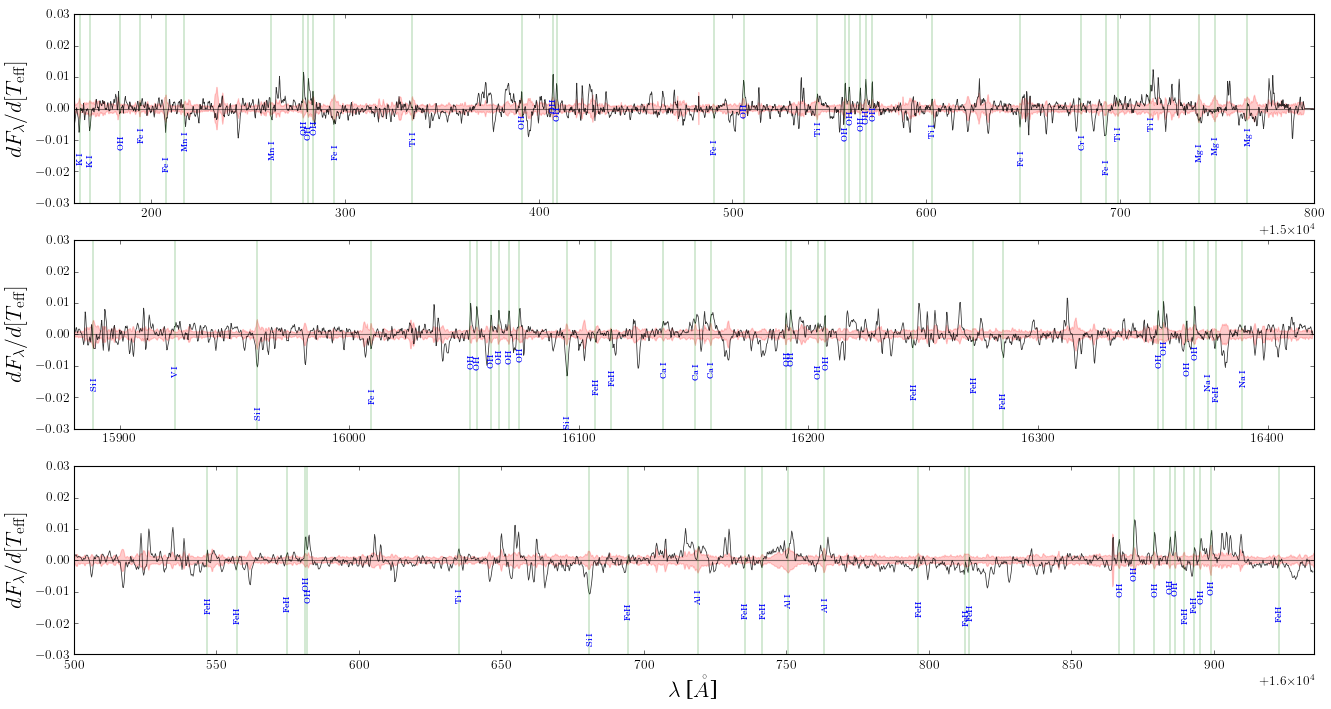

In [175]:
bands = [[15160,15800],[15880,16420],[16500,16935]]
pbands = [np.where((ds.wl > bands[0][0]) & (ds.wl < bands[0][1]))[0], \
    np.where((ds.wl > bands[1][0]) & (ds.wl < bands[1][1]))[0], \
    np.where((ds.wl > bands[2][0]) & (ds.wl < bands[2][1]))[0]]

k = 3
wave = ds.wl
flux = md.coeffs.T[k]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,10), facecolor='w', sharey=True)

ax1.plot(ds.wl[pbands[0]], md.coeffs.T[k][pbands[0]], color='k', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax1.set_xlim(bands[0])

ax2.plot(ds.wl[pbands[1]], md.coeffs.T[k][pbands[1]], color='k', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax2.set_xlim(bands[1])

ax3.plot(ds.wl[pbands[2]], md.coeffs.T[k][pbands[2]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[2])

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
        ypos = flux[index]
        plot_ypos_min = (ypos - yrange[0] +1)/(yrange[1] - yrange[0])
        plot_ypos_max = (ypos - yrange[0] -1)/(yrange[1] - yrange[0])

        if (feature >= bands[0][0]) & (feature <= bands[0][1]):
            ax1.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax1.text(feature, ypos-.01, lines, rotation=90, ha='center', color='b', fontsize=8)
       
        elif (feature >= bands[1][0]) & (feature <= bands[1][1]):
            ax2.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax2.text(feature, ypos-.015, lines, rotation=90, ha='center', color='b', fontsize=8)

        elif (feature >= bands[2][0]) & (feature <= bands[2][1]):
            ax3.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax3.text(feature, ypos-.015, lines, rotation=90, ha='center', color='b', fontsize=8)

plt.ylim(-.03,.03)
plt.show()

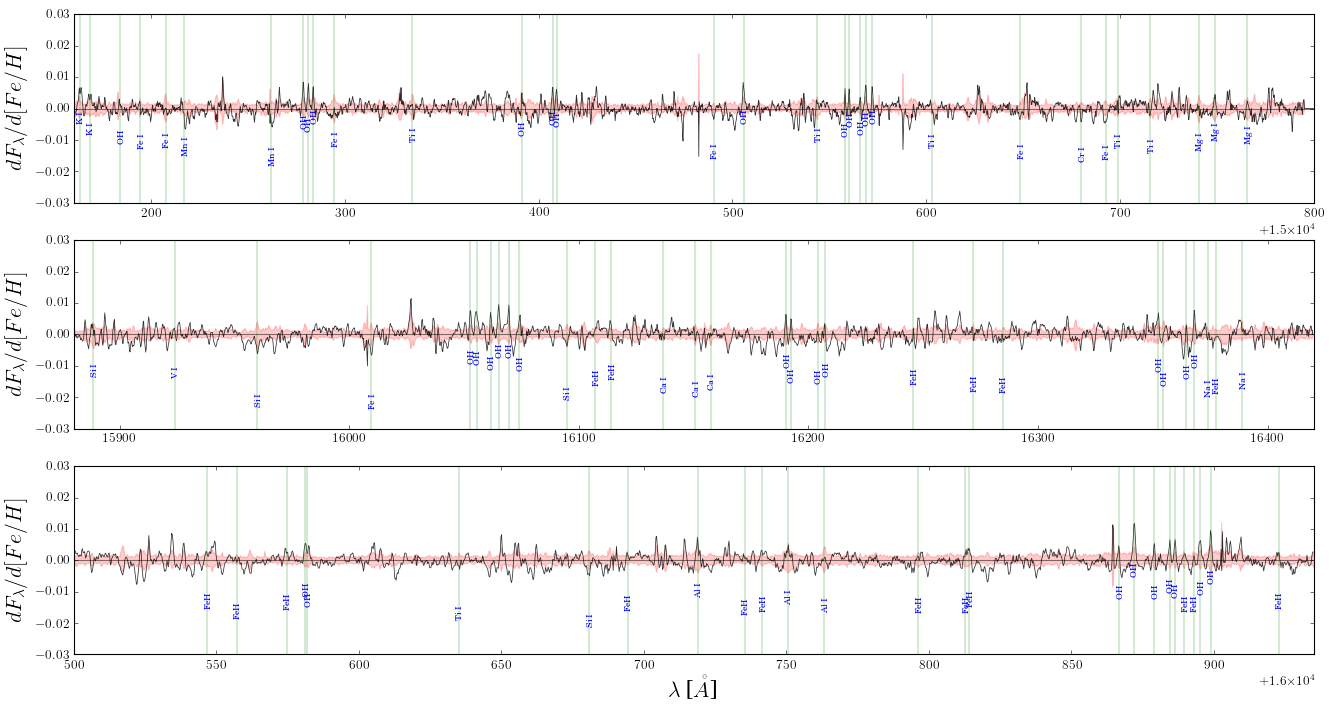

In [176]:
bands = [[15160,15800],[15880,16420],[16500,16935]]
pbands = [np.where((ds.wl > bands[0][0]) & (ds.wl < bands[0][1]))[0], \
    np.where((ds.wl > bands[1][0]) & (ds.wl < bands[1][1]))[0], \
    np.where((ds.wl > bands[2][0]) & (ds.wl < bands[2][1]))[0]]

k = 4
wave = ds.wl
flux = md.coeffs.T[k]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,10), facecolor='w', sharey=True)

ax1.plot(ds.wl[pbands[0]], md.coeffs.T[k][pbands[0]], color='k', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl, -jack_err_teff, jack_err_fe_h, alpha=.2, color='r')
ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax1.set_xlim(bands[0])

ax2.plot(ds.wl[pbands[1]], md.coeffs.T[k][pbands[1]], color='k', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl, -jack_err_teff, jack_err_fe_h, alpha=.2, color='r')
ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax2.set_xlim(bands[1])

ax3.plot(ds.wl[pbands[2]], md.coeffs.T[k][pbands[2]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_teff, jack_err_fe_h, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[2])

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
        ypos = flux[index]
        plot_ypos_min = (ypos - yrange[0] +1)/(yrange[1] - yrange[0])
        plot_ypos_max = (ypos - yrange[0] -1)/(yrange[1] - yrange[0])

        if (feature >= bands[0][0]) & (feature <= bands[0][1]):
            ax1.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax1.text(feature, ypos-.01, lines, rotation=90, ha='center', color='b', fontsize=8)
       
        elif (feature >= bands[1][0]) & (feature <= bands[1][1]):
            ax2.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax2.text(feature, ypos-.015, lines, rotation=90, ha='center', color='b', fontsize=8)

        elif (feature >= bands[2][0]) & (feature <= bands[2][1]):
            ax3.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax3.text(feature, ypos-.015, lines, rotation=90, ha='center', color='b', fontsize=8)

plt.ylim(-.03,.03)
plt.show()

In [200]:
n = 2
plotCannonModels(ds, synth, tst_labels, save=True, out='bonus_results/Models_Band'+str(n+1)+'.pdf', \
                 tr_lbl_unc=[60,.08], te_lbl_unc=[61,.08], snr=ds.test_SNR, band=n, lines=True)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [197]:
def plotCannonModels(ds, te_flux, te_labels, **kwargs):

    nspecs = len(te_flux)
    bands  = [[15160,15800],[15880,16420],[16500,16935]]
    n      = kwargs.get('band', 1)
    yrange = kwargs.get('yrange', [.5,1.2])
    lbl_names = kwargs.get('lbl_names', ['TEFF', 'FE/H'])
    snr = kwargs.get('snr', [])
    lines = kwargs.get('lines', False)
    
    save = kwargs.get('save', False)
    out  = kwargs.get('out', 'Models_Band'+str(n)+'.pdf')
    
    tr_label = ds.tr_label
    tr_label_unc = kwargs.get('tr_lbl_unc')
    te_label = te_labels
    te_label_unc = kwargs.get('te_lbl_unc', [0,0])
    
    wl = ds.wl
    tr_flux = ds.tr_flux
    tr_ivar = ds.tr_ivar
    
    fig, axs = plt.subplots(nspecs, 1, figsize=(12,4*nspecs))
    for i, ax in enumerate(fig.axes):

        tr_stdev = [1/math.sqrt(ivar) for ivar in tr_ivar[i]]
    
        data = ap.Spectrum(wave=wl, flux=tr_flux[i], sigmas=tr_stdev)
        mdl  = ap.Spectrum(wave=wl, flux=te_flux[i])
        chi  = round(ap.compareSpectra(data, mdl, fit_scale=False)[0],2)
        
        ax.plot(wl, tr_flux[i], color='k')
        ax.plot(wl, te_flux[i], color='r')
        
        try:
            cannon_lbl = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(te_label[i][0],-1), te_label_unc[i][0], round(te_label[i][1],2), te_label_unc[i][1]) 
        except:
            cannon_lbl = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(te_label[i][0],-1), te_label_unc[0], round(te_label[i][1],2), te_label_unc[1]) 
        ax.text(bands[n-1][0]+10, yrange[1]-.08, cannon_lbl,color='r', fontsize=15, va='bottom', ha='left')
        
        try:
            ref_lbl = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(tr_label[i][0],-1), tr_label_unc[i][0], round(tr_label[i][1],2), tr_label_unc[i][1]) 
        except:
            ref_lbl = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(tr_label[i][0],-1), tr_label_unc[0], round(tr_label[i][1],2), tr_label_unc[1]) 
        ax.text(bands[n-1][0]+10, yrange[0]+.08, ref_lbl, color='k', fontsize=15, va='top', ha='left')
        
        chi_lbl = r'$\chi^{2} = %s$'%(str(chi))
        ax.text(bands[n-1][1]-10, yrange[1]-.08, chi_lbl, color='r', fontsize=15, va='bottom', ha='right')
        
        if len(snr) != 0:
            snr_lbl = r'$SNR = {}$'.format(str(round(snr[i],2)))
            ax.text(bands[n-1][1]-10, yrange[0]+.08, snr_lbl, color='k', fontsize=15, va='top', ha='right')
        
        for lines in line_names:
            for feature in line_list[lines]:
                
                if (feature >= bands[n-1][0]) & (feature <= bands[n-1][1]):
                    # determine position of the line and label based on pixel of the spectrum
                    xpos = min(wave, key=lambda x:abs(x - feature))
                    index = list(wave).index(xpos)
                    ypos = tr_flux[i][index]

                    ax.axvline(x=feature, ymin=0, ymax=1, linewidth=.3, color='g', alpha=.7)
                    ax.text(feature, ypos-.1, lines, rotation=90, ha='center', color='b', fontsize=8)
        
        ax.set_title(r'${}$'.format(ds.tr_ID[i]), fontsize=20)
        ax.set_xlim(bands[n-1])
        ax.set_ylim(yrange)
        ax.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=15)
        if i == nspecs-1:
            ax.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=15)
    
    plt.tight_layout()
    if save == True:
        plt.savefig(str(out))
    plt.show()
    plt.close()

In [190]:
len(tr_flux)

76